In [1]:
import datetime as dt
import glob
import os
import pickle
import re
import string
import sys
import time
import warnings
from datetime import datetime
from pathlib import Path

import featuretools as ft
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import (
    stopwords,
    wordnet,
)
from nltk.stem import (
    PorterStemmer,
    WordNetLemmatizer,
)
from scipy.stats.mstats import winsorize
from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    normalize,
)
from tqdm import tqdm

nltk.download("wordnet")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tqdm.pandas()

In [3]:
PACKAGE_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PACKAGE_ROOT.parent))

In [4]:
PACKAGE_ROOT

PosixPath('/home/javier/repos/mle_challenge/model')

In [5]:
DATAPATH = os.path.join(PACKAGE_ROOT, "experiments/data")

In [6]:
DATAPATH

'/home/javier/repos/mle_challenge/model/experiments/data'

In [7]:
raw_train = pd.read_csv(os.path.join(DATAPATH, "train.csv"))
raw_test = pd.read_csv(os.path.join(DATAPATH, "test.csv"))

---

<center><h1>💻💻 Data Preparation 💻 💻</h1></center>

---

In [8]:
raw_train.sample(3)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
4002,11244,austin,Restrictions: Yes Sprinkler Sys:Yes,Townhouse,30.294041,-97.699791,2,False,2015,2,2178.0,5.000000,15,3.0,3,450000-650000
3547,5153,austin,"8519 Birmingham Dr, Austin, TX 78748 is a sing...",Single Family,30.181957,-97.804787,0,False,1983,2,5662.0,3.333333,14,2.0,3,250000-350000
4036,10910,austin,"11716 Larch Valley Dr, Austin, TX 78754 is a s...",Single Family,30.377497,-97.653625,2,False,2004,1,6098.0,4.333333,12,2.0,3,250000-350000


In [9]:
raw_test.dtypes

uid                             int64
city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                           bool
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                float64
numOfBedrooms                   int64
priceRange                     object
dtype: object

In [10]:
raw_train.shape, raw_test.shape

((9000, 16), (1000, 16))

In [11]:
PACKAGE_ROOT

PosixPath('/home/javier/repos/mle_challenge/model')

In [12]:
import model.packaging_ml_model.prediction_model.processing.preprocessing as pp
from model.packaging_ml_model.prediction_model.config import config

In [108]:
pipeline = Pipeline(
    [
        (
            "DataFrameTypeConverter",
            pp.DataFrameTypeConverter(conversion_dict=config.CONVERSION_DICT),
        ),
        (
            "DropColumns",
            pp.DropColumns(variables_to_drop=config.VARIABLES_TO_DROP),
        ),
        (
            "ModeImputer",
            pp.ModeImputer(variables=config.CATEGORICAL_FEATURES),
        ),
        (
            "DataFrameProcessor",
            pp.DataFrameProcessor(features=config.FEATURES_MODIFY, quantile_threshold=0.1),
        ),
        (
            "MedianImputer",
            pp.MedianImputer(variables=config.NUMERICAL_FEATURES),
        ),
        (
            "Winsorizer",
            pp.Winsorizer(numerical_features=config.NUMERICAL_FEATURES, limits=[0.025, 0.025]),
        ),
        (
            "DropColumns2",
            pp.DropColumns(variables_to_drop=config.NUMERICAL_FEATURES),
        ),
        (
            "CoordinateBinner",
            pp.CoordinateBinner(columns=config.GEOLOCATION, decimal_places=3),
        ),
        (
            "DropColumns3",
            pp.DropColumns(variables_to_drop=config.GEOLOCATION),
        ),
        (
            "TextProcessor",
            pp.TextProcessor(column=config.DESCRIPTION_FEATURE, blacklist=config.BLACK_LIST),
        ),
        (
            "TFIDFTransformer",
            pp.TFIDFTransformer(column=config.DESCRIPTION_FEATURE, max_features=20),
        ),
        (
            "NumericalFeatureSelector",
            pp.NumericalFeatureSelector(remove_columns=config.TO_REMOVE),
        ),
        (
            "LogTransforms",
            pp.LogTransforms(),
        ),
        (
            "DataScaler",
            pp.DataScaler(),
        ),
        (
            "CorrelationMatrixProcessor",
            pp.CorrelationMatrixProcessor(threshold=0.7),
        ),
        (
            "FeatureVariance",
            pp.FeatureVariance(threshold=0.001),
        ),
        (
            "DropColumns4",
            pp.DropColumns(variables_to_drop=config.DESCRIPTION_FEATURE),
        ),
        (
            "LabelEncoderProcessor",
            pp.LabelEncoderProcessor(),
        ),
        (
            "FeatureToolsProcessor",
            pp.FeatureToolsProcessor(max_depth=1, trans_primitives=["add_numeric", "multiply_numeric"]),
        ),
    ]
)

In [109]:
transformed_train = pipeline.fit_transform(raw_train)

Built 1024 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████


In [110]:
transformed_train.sample()

,city,homeType,hasSpa,priceRange,garageSpaces_winsor,yearBuilt_winsor,numOfPatioAndPorchFeatures_winsor,lotSizeSqFt_winsor,avgSchoolRating_winsor,numOfBathrooms_winsor,numOfBedrooms_winsor,homeType_count_winsor,latitude_winsor_3,longitude_winsor_3,area,back,backyard,build,ceiling,contain,family,feature,from,great,include,large,living,lot,new,open,update,walk,area + avgSchoolRating_winsor,area + back,area + backyard,area + build,area + ceiling,area + city,area + contain,area + family,area + feature,area + from,area + garageSpaces_winsor,area + great,area + hasSpa,area + homeType,area + homeType_count_winsor,area + include,area + large,area + latitude_winsor_3,area + living,area + longitude_winsor_3,area + lot,area + lotSizeSqFt_winsor,area + new,area + numOfBathrooms_winsor,area + numOfBedrooms_winsor,area + numOfPatioAndPorchFeatures_winsor,area + open,area + priceRange,area + update,area + walk,area + yearBuilt_winsor,avgSchoolRating_winsor + back,avgSchoolRating_winsor + backyard,avgSchoolRating_winsor + build,avgSchoolRating_winsor + ceiling,avgSchoolRating_winsor + city,avgSchoolRating_winsor + contain,avgSchoolRating_winsor + family,avgSchoolRating_winsor + feature,avgSchoolRating_winsor + from,avgSchoolRating_winsor + garageSpaces_winsor,avgSchoolRating_winsor + great,avgSchoolRating_winsor + hasSpa,avgSchoolRating_winsor + homeType,avgSchoolRating_winsor + homeType_count_winsor,avgSchoolRating_winsor + include,avgSchoolRating_winsor + large,avgSchoolRating_winsor + latitude_winsor_3,avgSchoolRating_winsor + living,avgSchoolRating_winsor + longitude_winsor_3,avgSchoolRating_winsor + lot,avgSchoolRating_winsor + lotSizeSqFt_winsor,avgSchoolRating_winsor + new,avgSchoolRating_winsor + numOfBathrooms_winsor,avgSchoolRating_winsor + numOfBedrooms_winsor,avgSchoolRating_winsor + numOfPatioAndPorchFeatures_winsor,avgSchoolRating_winsor + open,avgSchoolRating_winsor + priceRange,avgSchoolRating_winsor + update,avgSchoolRating_winsor + walk,avgSchoolRating_winsor + yearBuilt_winsor,back + backyard,back + build,back + ceiling,back + city,back + contain,back + family,back + feature,back + from,back + garageSpaces_winsor,back + great,back + hasSpa,back + homeType,back + homeType_count_winsor,back + include,back + large,back + latitude_winsor_3,back + living,back + longitude_winsor_3,back + lot,back + lotSizeSqFt_winsor,back + new,back + numOfBathrooms_winsor,back + numOfBedrooms_winsor,back + numOfPatioAndPorchFeatures_winsor,back + open,back + priceRange,back + update,back + walk,back + yearBuilt_winsor,backyard + build,backyard + ceiling,backyard + city,backyard + contain,backyard + family,backyard + feature,backyard + from,backyard + garageSpaces_winsor,backyard + great,backyard + hasSpa,backyard + homeType,backyard + homeType_count_winsor,backyard + include,backyard + large,backyard + latitude_winsor_3,backyard + living,backyard + longitude_winsor_3,backyard + lot,backyard + lotSizeSqFt_winsor,backyard + new,backyard + numOfBathrooms_winsor,backyard + numOfBedrooms_winsor,backyard + numOfPatioAndPorchFeatures_winsor,backyard + open,backyard + priceRange,backyard + update,backyard + walk,backyard + yearBuilt_winsor,build + ceiling,build + city,build + contain,build + family,build + feature,build + from,build + garageSpaces_winsor,build + great,build + hasSpa,build + homeType,build + homeType_count_winsor,build + include,build + large,build + latitude_winsor_3,build + living,build + longitude_winsor_3,build + lot,build + lotSizeSqFt_winsor,build + new,build + numOfBathrooms_winsor,build + numOfBedrooms_winsor,build + numOfPatioAndPorchFeatures_winsor,build + open,build + priceRange,build + update,build + walk,build + yearBuilt_winsor,ceiling + city,ceiling + contain,ceiling + family,ceiling + feature,ceiling + from,ceiling + garageSpaces_winsor,ceiling + great,ceiling + hasSpa,ceiling + homeType,ceiling + homeType_count_winsor,ceiling + include,ceiling + large,ceiling + latitude_winsor_3,ceiling + living,ceiling + longitude_winso

In [111]:
transformed_test = pipeline.fit_transform(raw_test)

Built 1024 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████


In [112]:
transformed_train.shape, transformed_test.shape

((9000, 1024), (1000, 1024))

In [113]:
list_train = list(transformed_train.columns)
list_test = list(transformed_test.columns)

In [114]:
transformed_train['priceRange'].value_counts()

priceRange
1    2123
2    2076
3    2054
4    1635
0    1112
Name: count, dtype: int64

In [115]:
no_common1 = [element for element in list_train if element not in list_test]
no_common2 = [element for element in list_test if element not in list_train]

In [116]:
no_common1

[]

In [117]:
no_common2

[]

In [118]:
train_y = transformed_train['priceRange']
train_X = transformed_train.drop(['priceRange'], axis=1)

In [119]:
#Let’s split X and y using Train test split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, train_size=0.8, random_state= 2022, stratify=train_y)

#get shape of train and test data
print("train data size:", X_train.shape)
print("test data size:", X_test.shape)

train data size: (7200, 1023)
test data size: (1800, 1023)


In [120]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(priceRange
 1    0.235833
 2    0.230694
 3    0.228194
 4    0.181667
 0    0.123611
 Name: proportion, dtype: float64,
 priceRange
 1    0.236111
 2    0.230556
 3    0.228333
 4    0.181667
 0    0.123333
 Name: proportion, dtype: float64)

In [121]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score

In [122]:
from sklearn.ensemble import StackingClassifier

In [123]:
from sklearn.model_selection import KFold

In [124]:
import time

In [125]:
def cv_score(ml_model, rstate=11, cols=None, df=None, df_y=None):
    start_time = time.time()

    if df is None or df_y is None:
        raise ValueError("DataFrames df and df_y must be provided")

    if cols is not None:
        df1 = df[cols].copy()
    else:
        df1 = df.copy()

    i = 1
    cv_scores = []
    
    kf = KFold(n_splits=5, random_state=rstate, shuffle=True)
    
    for train_index, test_index in kf.split(df1):
        xtr, xvl = df1.iloc[train_index], df1.iloc[test_index]
        ytr, yvl = df_y.iloc[train_index], df_y.iloc[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        
        # Calculate accuracy
        accuracy = accuracy_score(yvl, pred_val)
        
        # Save scores
        cv_scores.append(accuracy)
        i += 1
    end_time = time.time()
    
    print(f"The duration for training the model is: {(end_time - start_time)}")
    return cv_scores

In [126]:
random_forest_classifier = cv_score(RandomForestClassifier(n_estimators=100, random_state=20230916), df = X_train, df_y = y_train)

The duration for training the model is: 8.42798924446106


In [127]:
knn_neighbors_classifier = cv_score(KNeighborsClassifier(n_neighbors=3), df = X_train, df_y = y_train)

The duration for training the model is: 1.61124587059021


In [128]:
decision_tree_classifier = cv_score(DecisionTreeClassifier(random_state=20230916), df = X_train, df_y = y_train)

The duration for training the model is: 2.3610033988952637


In [129]:
xgb_classifier = cv_score(XGBClassifier(random_state=20230916), df = X_train, df_y = y_train)

The duration for training the model is: 50.340150117874146


In [130]:
results_df = pd.DataFrame({'RandomForestClassifier':random_forest_classifier, 
                           'KNeighborsClassifier': knn_neighbors_classifier, 
                           'DecisionTreeClassifier': decision_tree_classifier, 
                           'XGBClassifier': xgb_classifier})

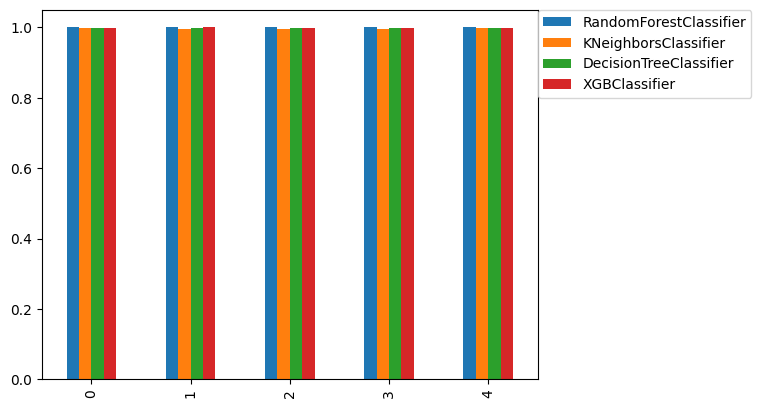

In [131]:
results_df.plot(y=["RandomForestClassifier", "KNeighborsClassifier", 'DecisionTreeClassifier', 'XGBClassifier'], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

In [132]:
# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=20230916)),
    ('xgb', XGBClassifier(random_state=20230916)),
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=meta_model,
                                  cv=5)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

In [133]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00       425
           2       1.00      1.00      1.00       415
           3       1.00      1.00      1.00       411
           4       1.00      1.00      1.00       327

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



In [134]:
# create the object of the model
model_xgb = XGBClassifier(random_state=20230916)

In [135]:
# Fit model 
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [136]:
feature_names = list(X_train.columns)

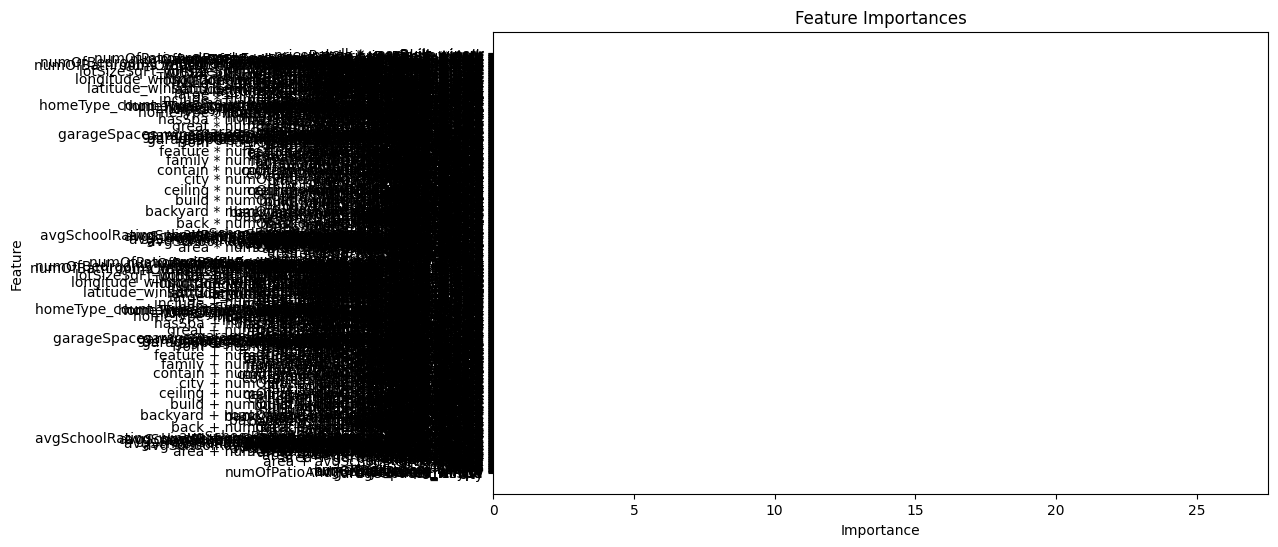

In [137]:
importances = model_xgb.feature_importances_

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances*100, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [146]:
feature_importance = pd.DataFrame({"features":feature_names, 
                                             "importances": importances*100})

feature_importance.sort_values(by='importances', ascending=False).head(10)

,features,importances
522,priceRange + walk,26.230022
172,build + priceRange,23.525026
145,backyard + priceRange,18.519976
719,city * priceRange,17.173990
223,city + priceRange,14.378901
313,from + priceRange,0.040027
883,homeType * priceRange,0.017015
521,priceRange + update,0.016578
333,garageSpaces_winsor + priceRange,0.015077
487,lotSizeSqFt_winsor + priceRange,0.014905


In [228]:
filtered_df =feature_importance[feature_importance['importances'] > 0.1]

In [229]:
features = list(filtered_df['features'])

In [230]:
len(features)

5

In [231]:
preds_class = model_xgb.predict(X_test)

In [232]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

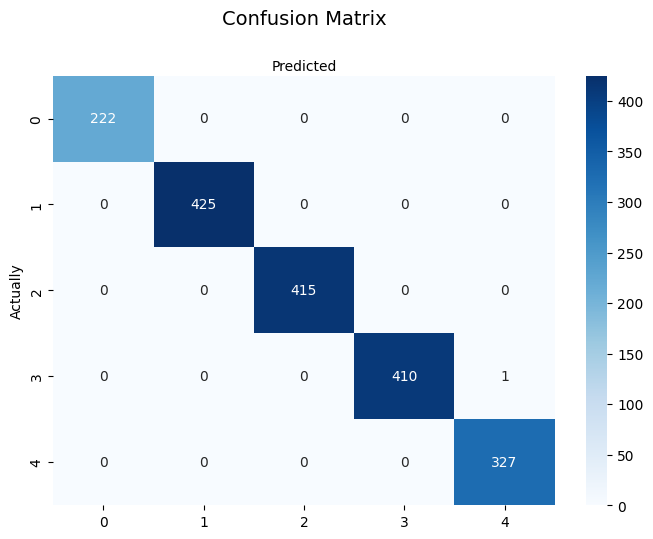

In [233]:
cm = pd.crosstab(y_test, preds_class, rownames=['Actually'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,5))

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g',)
ax1.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1,fontsize=14)
plt.show()

In [234]:
acc=accuracy_score(y_test,preds_class)
print('Accuracy =' , acc)

Accuracy = 0.9994444444444445


In [235]:
recall = recall_score(y_test, preds_class, average='macro')
print('Recall =' ,recall)

Recall = 0.9995133819951338


In [236]:
precision = precision_score(y_test, preds_class, average='macro')
print('Precision =' ,precision)

Precision = 0.999390243902439


# Hyperparameter Tunning

In [237]:
from sklearn.model_selection import GridSearchCV

In [238]:
RANDOM_SEED = 20230916

In [239]:
# RandomForest
rf = RandomForestClassifier(random_state=RANDOM_SEED)
param_grid_forest = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "criterion": ["gini", "entropy"],
    "max_leaf_nodes": [50, 100],
}

grid_forest = GridSearchCV(
    estimator=rf, param_grid=param_grid_forest, cv=5, n_jobs=-1, scoring="accuracy", verbose=0
)

model_forest = grid_forest.fit(X_train[features], y_train)

In [240]:
best_params_forest = grid_forest.best_params_

In [241]:
best_params_forest

{'criterion': 'gini',
 'max_depth': 5,
 'max_leaf_nodes': 50,
 'n_estimators': 100}

In [242]:
best_model = grid_forest.best_estimator_

In [243]:
predictions_forest = best_model.predict(X_test[features])

In [244]:
accuracy_forest = accuracy_score(y_test, predictions_forest)
print("Test accuracy:", accuracy_forest)

Test accuracy: 1.0


In [245]:
print("\nClassification Report:\n", classification_report(y_test, predictions_forest))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00       425
           2       1.00      1.00      1.00       415
           3       1.00      1.00      1.00       411
           4       1.00      1.00      1.00       327

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



## XGBClassifier

In [55]:
# XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=RANDOM_SEED)
param_grid_xgboost = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.5],
    "max_depth": [5, 10],
    "reg_alpha": [0.01, 0.1],
    "reg_lambda": [0.01, 0.1],
}

grid_xgboost = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_xgboost,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=0,
)
model_xgboost = grid_xgboost.fit(X_train, y_train)

In [60]:
best_params_xgboost = grid_xgboost.best_params_

In [58]:
best_model_xgboost = grid_xgboost.best_estimator_

In [61]:
best_params_xgboost

{'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 300,
 'reg_alpha': 0.01,
 'reg_lambda': 0.1}

In [64]:
predictions_xgboost = best_model_xgboost.predict(X_test)

In [65]:
accuracy_xgboost = accuracy_score(y_test, predictions_xgboost)
print("Test accuracy:", accuracy_xgboost)

Test accuracy: 0.5905555555555555


In [68]:
print("Accuracy:", accuracy_score(y_test, predictions_xgboost))
print("\nClassification Report:\n", classification_report(y_test, predictions_xgboost))

Accuracy: 0.5905555555555555

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.47      0.55       222
           1       0.57      0.61      0.59       425
           2       0.49      0.48      0.48       415
           3       0.55      0.59      0.57       411
           4       0.76      0.79      0.77       327

    accuracy                           0.59      1800
   macro avg       0.60      0.59      0.59      1800
weighted avg       0.59      0.59      0.59      1800



## Comparing both models

In [250]:
random_forest_classifier = cv_score(RandomForestClassifier(criterion='entropy',
                                                           max_depth= 15,
                                                           max_leaf_nodes= 100,
                                                           n_estimators= 200,
                                                           random_state=20230916), 
                                    df = X_train, df_y = y_train)

The duration for training the model is: 0.8944368362426758


In [251]:
xgb_classifier = cv_score(XGBClassifier(learning_rate= 0.1,
                                        max_depth= 10,
                                        n_estimators= 300,
                                        reg_alpha= 0.01,
                                        reg_lambda= 0.1, 
                                        random_state=20230916), 
                          df = X_train[features], df_y = y_train)

The duration for training the model is: 0.7300071716308594


In [252]:
results_df = pd.DataFrame({'RandomForestClassifier':random_forest_classifier, 
                           'XGBClassifier': xgb_classifier})

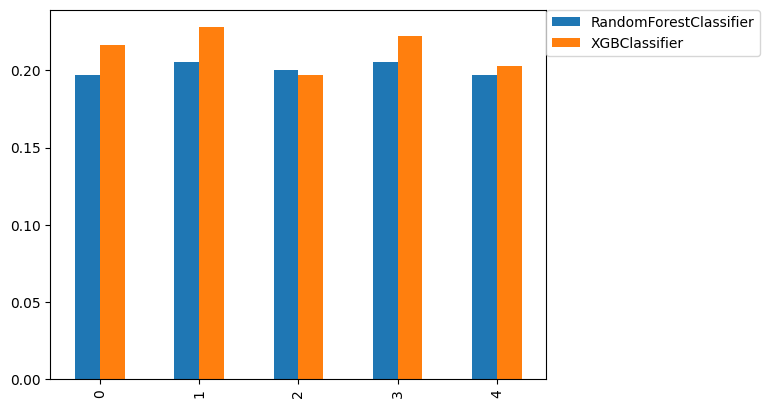

In [253]:
results_df.plot(y=["RandomForestClassifier", 'XGBClassifier'], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

## Stacking both models

In [84]:
# Base models
estimators = [
    ('rf', RandomForestClassifier(criterion='entropy',
                                  max_depth= 15,
                                  max_leaf_nodes= 100,
                                  n_estimators= 200,
                                  random_state=20230916)),
    ('xgb', XGBClassifier(learning_rate= 0.1,
                                  max_depth= 10,
                                  n_estimators= 300,
                                  reg_alpha= 0.01,
                                  reg_lambda= 0.1, 
                                  random_state=20230916)),
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=meta_model,
                                  cv=5)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

In [85]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6172222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60       222
           1       0.60      0.68      0.64       425
           2       0.53      0.49      0.51       415
           3       0.57      0.61      0.59       411
           4       0.76      0.79      0.77       327

    accuracy                           0.62      1800
   macro avg       0.64      0.61      0.62      1800
weighted avg       0.62      0.62      0.62      1800



In [104]:
modex_xgboost_best = XGBClassifier(learning_rate= 0.1,
                                   max_depth= 10,
                                   n_estimators= 300,
                                   reg_alpha= 0.01,
                                   reg_lambda= 0.1, 
                                   random_state=20230916)

In [105]:
# Fit model 
modex_xgboost_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [106]:
feature_names = list(X_train.columns)

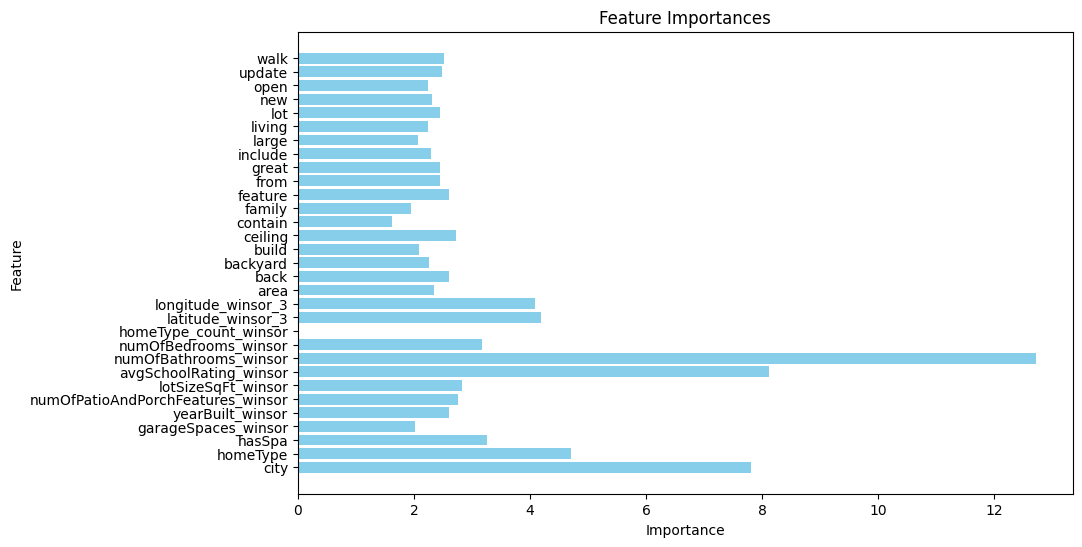

In [107]:
importances = modex_xgboost_best.feature_importances_

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances*100, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [43]:
feature_importance = pd.DataFrame({"features":feature_names, 
                                             "importances": importances*100})

feature_importance.sort_values(by='importances', ascending=False).head()

,features,importances
8,numOfBathrooms_winsor,14.309074
7,avgSchoolRating_winsor,9.902528
11,latitude_winsor_3,5.493628
12,longitude_winsor_3,5.361614
1,homeType,4.085618


In [44]:
feature_importance.describe().T

,count,mean,std,min,25%,50%,75%,max
importances,31.0,3.225806,2.66251,0.0,2.10761,2.226877,3.246574,14.309074


In [45]:
preds_class = model_xgb.predict(X_test)

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

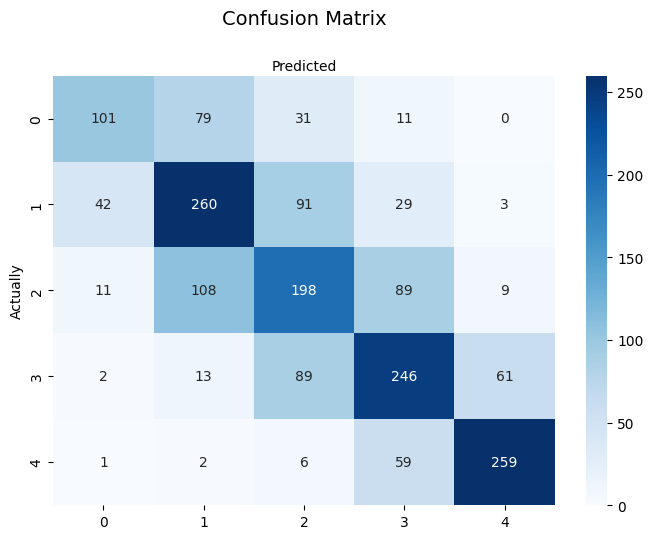

In [51]:
cm = pd.crosstab(y_test, preds_class, rownames=['Actually'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,5))

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g',)
ax1.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1,fontsize=14)
plt.show()

In [48]:
acc=accuracy_score(y_test,preds_class)
print('Accuracy =' , acc)

Accuracy = 0.5911111111111111


In [49]:
recall = recall_score(y_test, preds_class, average='macro')
print('Recall =' ,recall)

Recall = 0.5868834340442516


In [50]:
precision = precision_score(y_test, preds_class, average='macro')
print('Precision =' ,precision)

Precision = 0.6060263713683474


In [103]:
importances = model_xgboost.feature_importances_

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances*100, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [43]:
feature_importance = pd.DataFrame({"features":feature_names, 
                                             "importances": importances*100})

feature_importance.sort_values(by='importances', ascending=False).head()

,features,importances
8,numOfBathrooms_winsor,14.309074
7,avgSchoolRating_winsor,9.902528
11,latitude_winsor_3,5.493628
12,longitude_winsor_3,5.361614
1,homeType,4.085618


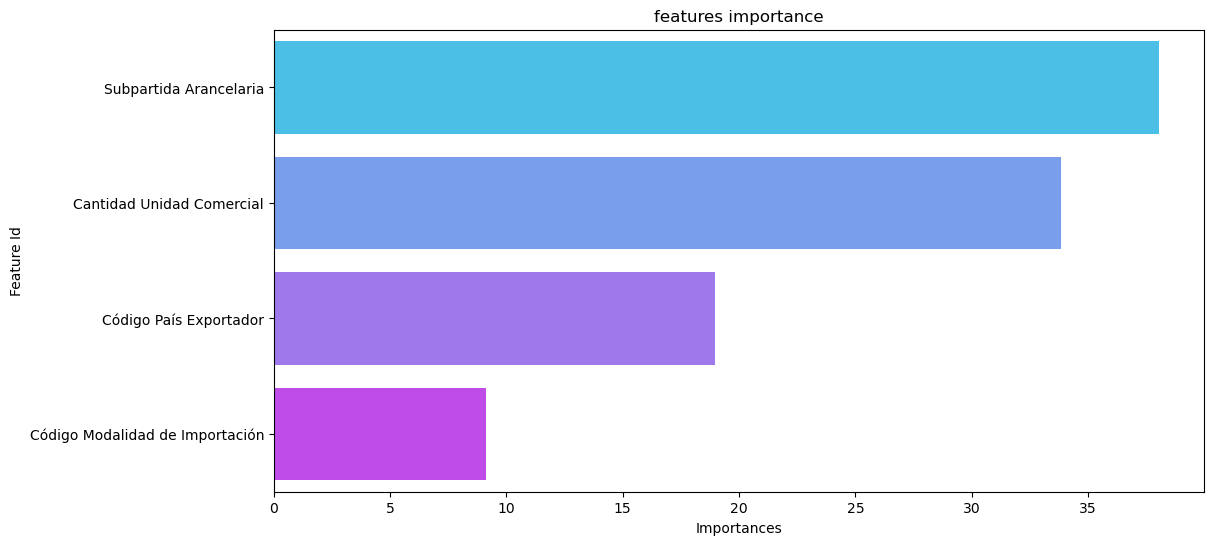

In [583]:
# Create a dataframe of feature importance 
model_cat_feature_importance = pd.DataFrame(model_cat.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=model_cat_feature_importance,palette="cool");
plt.title('features importance');

In [584]:
model_cat_feature_importance = pd.DataFrame(model_cat.get_feature_importance(prettified=True))

model_cat_feature_importance

,Feature Id,Importances
0,Subpartida Arancelaria,38.070762
1,Cantidad Unidad Comercial,33.830246
2,Código País Exportador,18.965225
3,Código Modalidad de Importación,9.133767


In [586]:
preds_class = model_cat.predict(test_data)

In [587]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score,f1_score,classification_report

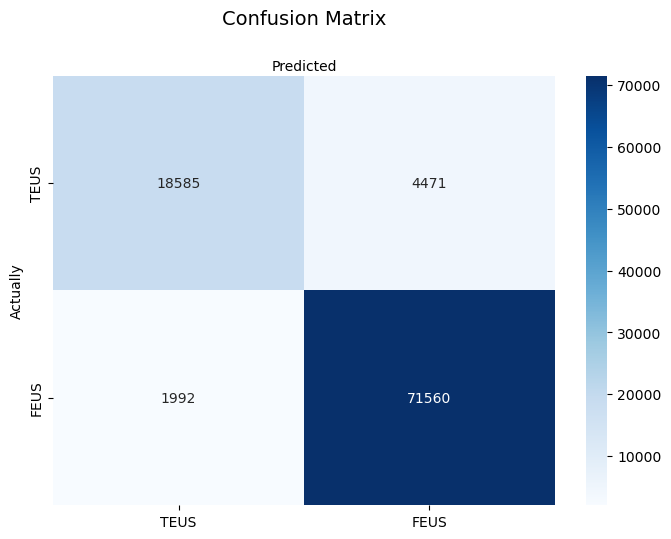

In [588]:
cm = pd.crosstab(y_test, preds_class, rownames=['Actually'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,5))

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g',
            xticklabels=['TEUS','FEUS'],
            yticklabels=['TEUS','FEUS'],)
ax1.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1,fontsize=14)
plt.show()

In [589]:
acc=accuracy_score(y_test,preds_class)
print('Accuracy =' , acc)

Accuracy = 0.9331007784034449


In [590]:
recall = recall_score(y_test, preds_class)
print('Recall =' , recall)

Recall = 0.9729171198607788


In [591]:
precision = precision_score(y_test, preds_class)
print('Precision =' ,precision)

Precision = 0.9411950388657259


In [592]:
auc_score=roc_auc_score(y_test, preds_class)
print('AUC =' , auc_score)

AUC = 0.8894989832475303


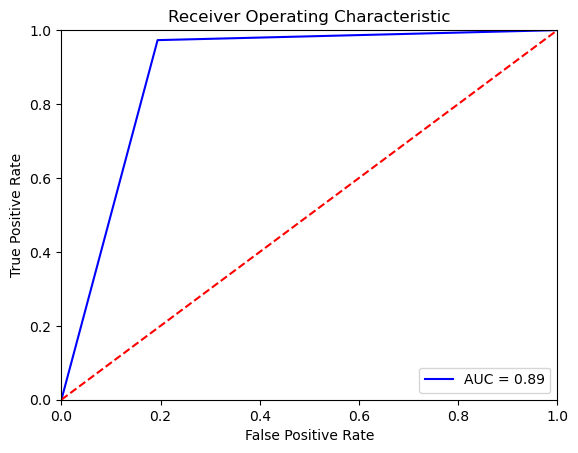

In [593]:
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_class)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [594]:
classification_report_score = classification_report(y_test, preds_class)
print(classification_report_score)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     23056
           1       0.94      0.97      0.96     73552

    accuracy                           0.93     96608
   macro avg       0.92      0.89      0.90     96608
weighted avg       0.93      0.93      0.93     96608



# CatBoost Regressor Model

Consider the following dataset:

In [ ]:
# Listing the Numerical datatypes
numerical_rel = list(new_data.select_dtypes(include=['int64','float64','Int64']).columns)

numerical_rel

In [599]:
agp_new[variable] = agp_new[variable].applymap(str)

In [600]:
agp_new[variable].dtypes

Código Depósito                                object
Código País Exportador                         object
Código Modalidad de Importación                object
Subpartida Arancelaria                         object
Nombre Estado Documento                        object
Código Modo Transporte                         object
Código Tipo Declaración                        object
Nombre Tipo Declaración                        object
Nombre Modo Transporte                         object
Código País Compra                             object
Nombre País Compra                             object
Nombre País Exportador                         object
Código País Origen                             object
Nombre País Origen                             object
Código País                                    object
Nombre País                                    object
Nombre Embalaje                                object
Periodo                                        object
Tipo Conocimiento           

In [661]:
# considering the categorical variables, the numerical ones, and the final target for classification case with the gt20 feature for the regressor case

final_regre = final_feat + ['gt20']

In [662]:
AGP_reg = agp_new[final_regre]

In [663]:
#AGP['final_target'] = AGP['final_target'].astype('category')

In [664]:
AGP_reg = AGP_reg.drop('final_target', axis=1)

In [665]:
AGP_reg.head()

,Código Modalidad de Importación,Código País Exportador,Subpartida Arancelaria,Cantidad Unidad Comercial,gt20
1,C190,PA,5205120000,0.798008,0.741276
15,C101,CA,713409000,0.815473,0.959135
16,C200,CN,8502121000,0.352793,0.741276
30,C130,CL,303130000,0.796893,0.741276
31,C100,CL,808100000,0.797814,0.741276


In [700]:
# Listing the Numerical datatypes
categorical_final = list(AGP_reg.select_dtypes(include=['object']).columns)

categorical_final

['Código Modalidad de Importación',
 'Código País Exportador',
 'Subpartida Arancelaria']